<a href="https://colab.research.google.com/github/sarveshc30/Spam-Identifier/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Getting Kaggle api

In [3]:
!pip install kaggle

In [ ]:
#from google.colab import drive
#drive.mount("/content/drive")

In [4]:
! mkdir ~/.kaggle/

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/ColabNotebooks/kaggle.json': No such file or directory


In [5]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


# Downloading Dataset

In [6]:
! kaggle datasets download uciml/sms-spam-collection-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 102MB/s]


In [7]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/spam.csv', encoding='latin-1')
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2128,ham,Well I'm going to be an aunty!,NaN,NaN,NaN
3583,spam,Hi 07734396839 IBH Customer Loyalty Offer: The...,NaN,NaN,NaN
4426,ham,So what did the bank say about the money?,NaN,NaN,NaN
706,ham,So when do you wanna gym harri,NaN,NaN,NaN
1930,ham,Carry on not disturbing both of you,NaN,NaN,NaN


In [9]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [10]:
df.rename(columns={'v1':'label', 'v2':'text'}, inplace=True)
df.sample(5)

,label,text
677,ham,"Piggy, r u awake? I bet u're still sleeping. I..."
2681,ham,I'm on da bus going home...
1636,ham,"No shit, but I wasn't that surprised, so I wen..."
3896,ham,No. Thank you. You've been wonderful
2168,ham,Thx. All will be well in a few months


In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

In [12]:
df.drop_duplicates(keep='first', inplace=True)

<Axes: xlabel='charCnt', ylabel='Count'>

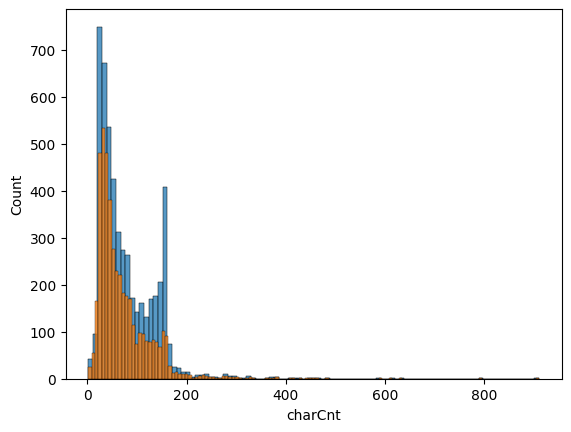

In [15]:
import seaborn as sns
df['charCnt'] = df['text'].apply(len)
sns.histplot(df['charCnt'])
sns.histplot(df[df['label'] == 0]['charCnt'])

<Axes: ylabel='label'>

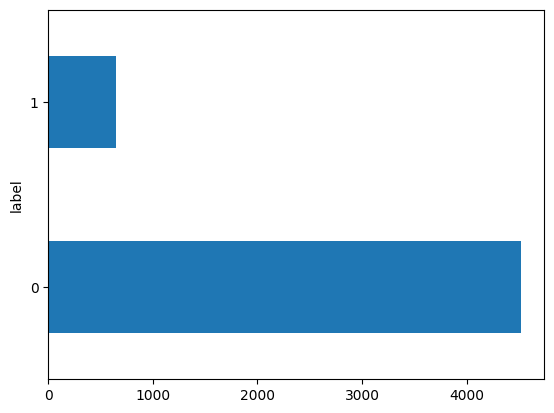

In [ ]:
df.label.value_counts().plot(kind = 'barh')

In [13]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

<Axes: xlabel='wordCnt', ylabel='Count'>

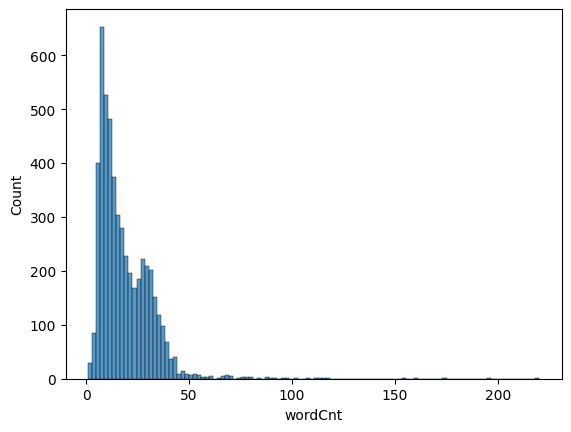

In [16]:
#no of words
df['wordCnt'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
sns.histplot(df['wordCnt'])

<Axes: >

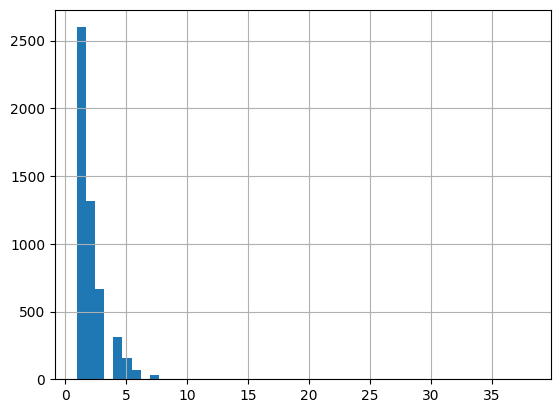

In [17]:
#no of sentences
df['sentCnt'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.sentCnt.hist(bins = 50, histtype = 'barstacked')

<Axes: xlabel='charCnt', ylabel='Count'>

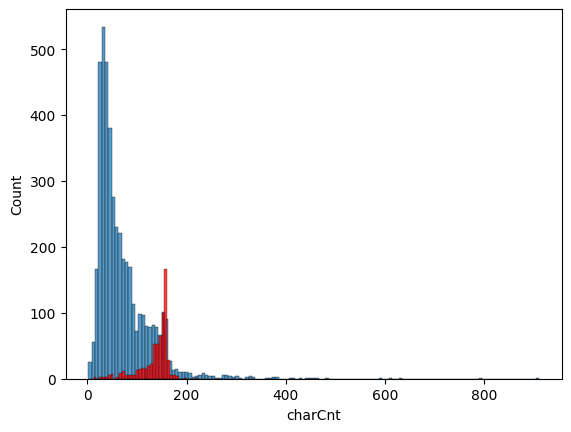

In [ ]:
sns.histplot(df[df['label'] == 0]['charCnt'])
sns.histplot(df[df['label'] == 1]['charCnt'], color = 'red')

In [ ]:
df.sample(5)

,label,text,charCnt,wordCnt,sentCnt
205,0,ÌÏ say until like dat i dun buy ericsson oso c...,64,15,1
4234,1,FREEMSG: Our records indicate you may be entit...,157,34,3
3715,0,Networking technical support associate.,39,5,1
4640,0,Havent.,7,2,1
3900,0,That depends. How would you like to be treated...,50,13,3


In [18]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [20]:
text = df['text']
label = df['label']
text_train, text_test, label_train, label_test = train_test_split(text, label, train_size = 0.7, shuffle = True, random_state=1)

In [21]:
#Padding and vectorization, and array

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 30000)
tokenizer.fit_on_texts(text_train)
tokenizer.word_index
sequences = tokenizer.texts_to_sequences(text_train)
max_word = np.max(df['wordCnt'])
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen = max_word, padding = 'post')
train_text_array = np.array(padded)
train_text_array.shape

(3618, 220)

# TF Model

In [22]:

inputs = tf.keras.Input(shape = (max_word,))
embedding = tf.keras.layers.Embedding(
    input_dim = 30000,
    output_dim = 64,
   )(inputs)

flatten = tf.keras.layers.Flatten()(embedding)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(flatten)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy',
    tf.keras.metrics.AUC(name = 'auc')]
)

print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 220)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 220, 64)             │       1,920,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14080)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          14,081 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,934,081 (7.38 MB)

 Trainable params: 1,934,081 (7.38 MB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
history = model.fit(
    train_text_array,
    label_train,
    validation_split = 0.2,
    batch_size = 32,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 3,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8722 - auc: 0.6577 - loss: 0.3541 - val_accuracy: 0.9793 - val_auc: 0.9665 - val_loss: 0.1417
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9595 - auc: 0.9657 - loss: 0.1325 - val_accuracy: 0.9848 - val_auc: 0.9920 - val_loss: 0.0677
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9872 - auc: 0.9966 - loss: 0.0513 - val_accuracy: 0.9834 - val_auc: 0.9950 - val_loss: 0.0558
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9909 - auc: 0.9989 - loss: 0.0349 - val_accuracy: 0.9848 - val_auc: 0.9961 - val_loss: 0.0482
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9938 - auc: 0.9997 - loss: 0.0206 - val_accuracy: 0.9862 - val_auc: 0.9960 - val_loss: 0.0478
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9981 - auc: 1.0000 - loss: 0.0114 - val_accuracy: 0.9862 - val_auc: 0.9963 - val_loss: 0.0453
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3

In [24]:
#Padding and vectorization, and array

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 30000)
tokenizer.fit_on_texts(text_test)
tokenizer.word_index
sequences = tokenizer.texts_to_sequences(text_test)
max_word = np.max(df['wordCnt'])
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen = max_word, padding = 'post')
text_test_array = np.array(padded)
text_test_array.shape

(1551, 220)

# Model Accuracy

Text(0.5, 1.0, 'Accuracy')

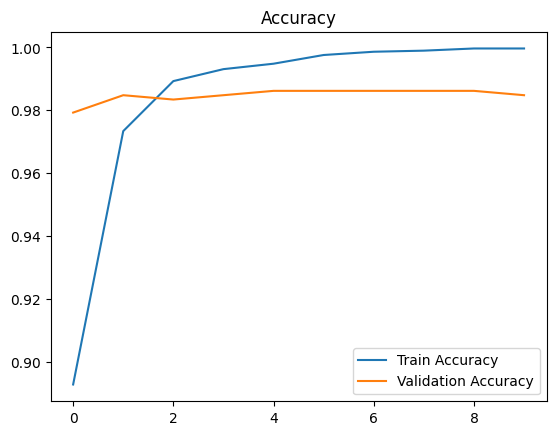

In [25]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')


# Model Loss

Text(0.5, 1.0, 'Loss')

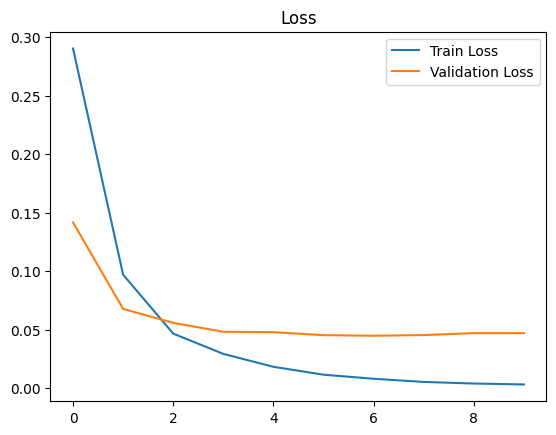

In [26]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# Model Evaluation on Testing Data

In [ ]:
results = model.evaluate(text_test_array, label_test, verbose = 0)
print("Test Loss: ", (results[0]))
print("Test Accuracy: ", results[1])


Test Loss:  0.6515637636184692
Test Accuracy:  0.8594455122947693
Test AUC:  0.6113510131835938
